### This notebook contains early-stage experimentation, exploratory analysis, and feature prototyping.The final, cleaned analysis and modeling pipeline is available on the `main` branch.

## The Data Collection/Extraction Stages.
### The goal is to have audio features for each track as well as # of streams across all platforms. We will attempt to predict the # of streams based on the track's audio features.
1. Pull a sample of metal tracks released starting 2005 from Chartmetric. The data includes Spotify and other platforms' # of streams, as well as ISRC (International Standard Recording Code). This number is shared between multiple versions of the same song (e.g. album vs. single, remastered versions etc.), but belongs to essential the same track.
2. Spotify no longer allows to use its data for AI training and deprecated the API for pulling tracks' audio features, so we will use a third party API - Reccobeats to calculate audio features for each track.
3. Need to create a script to pull audio features from Reccobeats based on ISCRC for each song on the Chartmetric dataset.
4. Since ISRC can pull multiple versions of the same song, need to calculate the mean for each audio feature to closely approximate the most popular version's features. Reccobeats API currently does not provide the song's stream data, so it is not possible to pull only the audio features of the main version. Averaging out accross multiple versions of the song would be a solid option.


In [1]:
#import libraries

#data analysis
from pathlib import Path
project_root = Path.cwd().parent
import pandas as pd
import numpy as np

#API
import requests
import json
import time

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Data Analysis

In [2]:
#Load chartmetrics data
raw_data_path =  project_root/"data"/"raw"
chart_df = pd.read_csv(raw_data_path/ "chartmetric_raw.csv")
print(chart_df.shape)
#/Users/test/Desktop/Data_Science/GIT/
chart_df.head(5)

(6800, 30)


,Track,Album Name,Artists,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,Deezer Playlist Count,Deezer Playlist Reach,Amazon Music Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazams,TIDAL Popularity,Explicit Track,Shortlists
0,Psychosocial,Psychosocial,Slipknot,2008-07-08,NLA320886993,"1,912",97.14,"808,166,393","172,861","23,649,176",...,20.0,"277,509",34.0,"128,354,144","82,682","14,547,258",NaN,NaN,0,NaN
1,Stricken,Stricken,Disturbed,2005-07-20,USRE10500766,"6,688",95.45,"466,331,168","92,604","17,799,301",...,7.0,"201,307",24.0,"316,520,872","63,786","6,196,954",NaN,NaN,0,NaN
2,Unsainted,Unsainted,Slipknot,2019-05-16,NLA321900089,"8,169",95.10,"379,175,553","85,612","9,081,286",...,13.0,"109,511",24.0,"37,473,127","13,403","633,800","524,502",NaN,1,NaN
3,Sanctified with Dynamite,Blood of the Saints,Powerwolf,2011-07-29,USMBR1108247,"9,865",94.75,"62,337,875","19,076","1,982,796",...,2.0,"4,037",11.0,NaN,NaN,"154,715","62,296",NaN,0,NaN
4,Nero Forte,We Are Not Your Kind,Slipknot,2019-08-09,NLA321900097,"12,992",94.19,"205,529,233","52,321","6,025,170",...,7.0,"67,513",4.0,"20,807,156","5,627","398,199","304,875",NaN,1,NaN


In [3]:
#Chek for null values and type
chart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Track                        6800 non-null   object 
 1   Album Name                   6800 non-null   object 
 2   Artists                      6800 non-null   object 
 3   Release Date                 6800 non-null   object 
 4   ISRC                         6800 non-null   object 
 5   All Time Rank                6800 non-null   object 
 6   Track Score                  6800 non-null   float64
 7   Spotify Streams              6762 non-null   object 
 8   Spotify Playlist Count       6800 non-null   object 
 9   Spotify Playlist Reach       6800 non-null   object 
 10  Spotify Popularity           6749 non-null   object 
 11  YouTube Views                3642 non-null   object 
 12  YouTube Likes                3640 non-null   object 
 13  TikTok Videos     

### We are seeing a lot of null data in the dataset, however we are mostly interested in Spotify stream counts, as it is the biggest platform. We are also seeing that a lot of numeric data is identified as object, which we will correct as well.  So we will reload the dataset only using the relevant columns, correct data types and decide what to do with null values


In [4]:
null_count=chart_df['Spotify Streams'].count()
null_perc = 1-null_count/chart_df.shape[0]
print(null_perc)

0.005588235294117672


In [5]:

#we are only missing a tiny proportion of data in spotify streams column. We could safely drop the null values
#define list of columns to load:
cols = [0,2,3,4,7,28]
chart_df = pd.read_csv(raw_data_path/ "chartmetric_raw.csv", usecols=cols, parse_dates = [2],dtype = {"Spotify Streams":"str"})
chart_df.shape
chart_df.head(5)

,Track,Artists,Release Date,ISRC,Spotify Streams,Explicit Track
0,Psychosocial,Slipknot,2008-07-08,NLA320886993,"808,166,393",0
1,Stricken,Disturbed,2005-07-20,USRE10500766,"466,331,168",0
2,Unsainted,Slipknot,2019-05-16,NLA321900089,"379,175,553",1
3,Sanctified with Dynamite,Powerwolf,2011-07-29,USMBR1108247,"62,337,875",0
4,Nero Forte,Slipknot,2019-08-09,NLA321900097,"205,529,233",1


In [6]:
chart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Track            6800 non-null   object        
 1   Artists          6800 non-null   object        
 2   Release Date     6800 non-null   datetime64[ns]
 3   ISRC             6800 non-null   object        
 4   Spotify Streams  6762 non-null   object        
 5   Explicit Track   6800 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 318.9+ KB


In [7]:
#The column "Spotify Streams" is still dtype object, however due to NA values Pands is struggling to parse it as integer.
#Convert "Spotify Streams" into int64.
chart_df["Spotify Streams"] = chart_df["Spotify Streams"].str.replace(",", "").astype("Int64")
chart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Track            6800 non-null   object        
 1   Artists          6800 non-null   object        
 2   Release Date     6800 non-null   datetime64[ns]
 3   ISRC             6800 non-null   object        
 4   Spotify Streams  6762 non-null   Int64         
 5   Explicit Track   6800 non-null   int64         
dtypes: Int64(1), datetime64[ns](1), int64(1), object(3)
memory usage: 325.5+ KB


In [8]:
#drop null values
chart_df= chart_df.dropna()
chart_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6762 entries, 0 to 6799
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Track            6762 non-null   object        
 1   Artists          6762 non-null   object        
 2   Release Date     6762 non-null   datetime64[ns]
 3   ISRC             6762 non-null   object        
 4   Spotify Streams  6762 non-null   Int64         
 5   Explicit Track   6762 non-null   int64         
dtypes: Int64(1), datetime64[ns](1), int64(1), object(3)
memory usage: 376.4+ KB


In [9]:
url = "https://api.reccobeats.com/v1/audio-features"

payload = {}
headers = {
'Accept': 'application/json'
}
track_isrc = ['NLA320886993','USRE10500766']
params = {"ids":track_isrc}
response = requests.request("GET", url, headers=headers, data=payload, params = params)

data = response.json()
print(json.dumps(data, indent=2))

{
  "content": [
    {
      "id": "04c4222a-9b78-46a7-b28a-20f32ca60075",
      "href": "https://open.spotify.com/track/4fjvlTcLlgiuvqBi5E9yJU",
      "isrc": "NLA320886993",
      "acousticness": 0.00269,
      "danceability": 0.568,
      "energy": 0.981,
      "instrumentalness": 0.00275,
      "key": 2,
      "liveness": 0.0243,
      "loudness": -3.889,
      "mode": 1,
      "speechiness": 0.0887,
      "tempo": 135.146,
      "valence": 0.307
    },
    {
      "id": "71b654f0-92e4-4dbb-936a-eface247ba9d",
      "href": "https://open.spotify.com/track/2MvIMgtWyK88OiPi0J8Dg3",
      "isrc": "NLA320886993",
      "acousticness": 0.00252,
      "danceability": 0.576,
      "energy": 0.989,
      "instrumentalness": 0.0032,
      "key": 2,
      "liveness": 0.0243,
      "loudness": -1.909,
      "mode": 1,
      "speechiness": 0.112,
      "tempo": 135.093,
      "valence": 0.352
    },
    {
      "id": "7fb12dc4-8043-4133-be82-4d634e486e24",
      "href": "https://open.spotify.c

## Here is the description of fields from Reccobeats
|       Field      |  Type |                                           Description                                           |
|:----------------:|:-----:|:-----------------------------------------------------------------------------------------------:|
| acousticness     | Float | Confidence (0.0 to 1.0) that the track is acoustic. Higher values indicate more natural sounds. |
| danceability     | Float | Suitability for dancing (0.0 to 1.0). Higher values indicate more rhythmically engaging tracks. |
| energy           | Float | Intensity and liveliness (0.0 to 1.0). Higher values indicate more energetic tracks.            |
| instrumentalness | Float | Likelihood of no vocals (0.0 to 1.0). Values above 0.5 suggest instrumental tracks.             |
| liveness         | Float | Probability of a live audience (0.0 to 1.0). Values above 0.8 strongly suggest a live track.    |
| loudness         | Float | Average loudness in decibels (dB). Typically ranges between -60 and 0 dB.                       |
| speechiness      | Float | Presence of spoken words (0.0 to 1.0). Values above 0.66 indicate mostly speech.                |
| tempo            | Float | Estimated tempo in beats per minute (BPM). Typically ranges between 0 and 250.                  |
| valence          | Float | Emotional tone (0.0 to 1.0). Higher values indicate a happier mood, lower values a sadder one.  |



### We can see that for each of the isrc we get multiple results. We will plot the parameters for different versions of the same isrc to see how big the difference is.

In [10]:
#Create df for plotting
track_data = pd.DataFrame(data['content'])
col_names=list(track_data.keys())
col_names

['id',
 'href',
 'isrc',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence']

In [11]:
#extract features
features = col_names[3:]
X = track_data[features]

#initialize scaler and transform values
scaler=MinMaxScaler()
X_scaled = scaler.fit_transform(X)
track_data_scaled = track_data.copy()

#Replace original columns with scaled values
track_data_scaled[features] = X_scaled

In [12]:
track_data_scaled.head()

,id,href,isrc,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,04c4222a-9b78-46a7-b28a-20f32ca60075,https://open.spotify.com/track/4fjvlTcLlgiuvqB...,NLA320886993,1.000000,0.954023,0.6,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.001367,0.500000
1,71b654f0-92e4-4dbb-936a-eface247ba9d,https://open.spotify.com/track/2MvIMgtWyK88OiP...,NLA320886993,0.934741,1.000000,1.0,0.015126,0.0,0.000000,1.000000,0.0,0.252438,0.000000,1.000000
2,7fb12dc4-8043-4133-be82-4d634e486e24,https://open.spotify.com/track/3RAFcUBrCNaboRX...,NLA320886993,1.000000,0.954023,0.6,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.001367,0.500000
3,b70a5b00-0261-4db1-9bf3-23e3d7fbb091,https://open.spotify.com/track/5YyBlKbVnHufwah...,USRE10500766,0.000000,0.022989,0.0,0.280672,1.0,1.000000,0.480303,0.0,0.826652,1.000000,0.411111
4,6f086275-3899-4803-a62b-78cec9112900,https://open.spotify.com/track/6RJdYpFQwLyNfDc...,USRE10500766,0.002457,0.000000,0.0,1.000000,1.0,0.823554,0.537374,0.0,1.000000,0.999201,0.000000


In [13]:
#convert df into long format for plotting
track_df_long = track_data_scaled.melt(
    id_vars=["isrc", "id"],
    value_vars=features,
    var_name="feature",
    value_name="value_norm"
)

In [14]:
track_df_long

,isrc,id,feature,value_norm
0,NLA320886993,04c4222a-9b78-46a7-b28a-20f32ca60075,acousticness,1.000000
1,NLA320886993,71b654f0-92e4-4dbb-936a-eface247ba9d,acousticness,0.934741
2,NLA320886993,7fb12dc4-8043-4133-be82-4d634e486e24,acousticness,1.000000
3,USRE10500766,b70a5b00-0261-4db1-9bf3-23e3d7fbb091,acousticness,0.000000
4,USRE10500766,6f086275-3899-4803-a62b-78cec9112900,acousticness,0.002457
...,...,...,...,...
336,USRE10500766,2d6270e5-5cdc-4c46-af02-e16d5ab80819,valence,0.411111
337,USRE10500766,4ba9fceb-cccd-44e7-ad66-0c508d7592e2,valence,0.411111
338,USRE10500766,401c9b48-c739-4dfd-a9e3-8376d5d3c3c0,valence,0.411111
339,NLA320886993,b3484fbc-ed9f-4ffb-bfe5-b5f6a1f31278,valence,0.511111


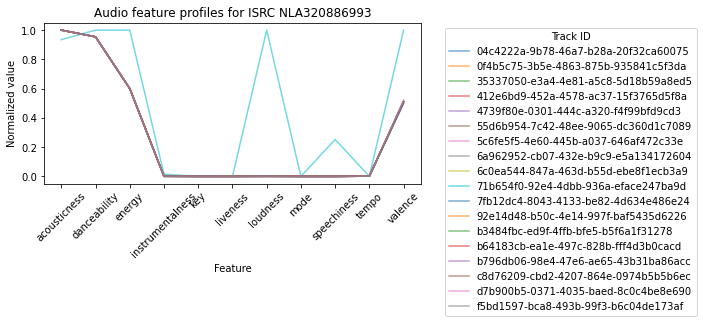

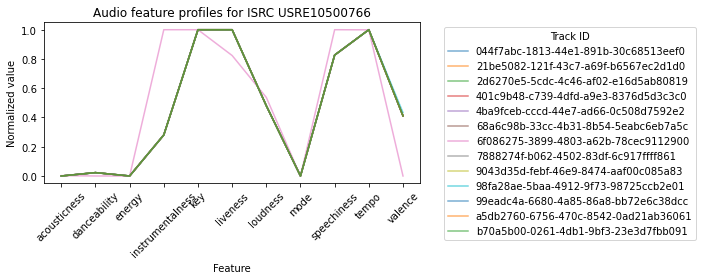

In [15]:
#we will plot the different versions of the same isrc to see if the difference between them is significant
for isrc, g_isrc in track_df_long.groupby("isrc"):
    plt.figure(figsize=(10, 4))

    for track_id, g_track in g_isrc.groupby("id"):
        plt.plot(
            g_track["feature"],
            g_track["value_norm"],
            label=track_id,
            alpha=0.6
        )

    plt.title(f"Audio feature profiles for ISRC {isrc}")
    plt.ylabel("Normalized value")
    plt.xlabel("Feature")
    plt.xticks(rotation=45)
    plt.legend(
    title="Track ID",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
    plt.tight_layout()
    plt.show()

### As we can see the majority of the features overlap, but there are tracks that are one off,

In [16]:
#confirm that indeed the features overlap and it's not a plotting error
track_data_scaled.groupby("isrc")[features].nunique()
#we can see most features for the same isrc have 1-3 unique values only 

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
isrc,,,,,,,,,,,
NLA320886993,2,2,2,3,1,1,3,1,2,3,4
USRE10500766,2,2,1,2,1,2,2,1,2,2,3


In [17]:
#Also confirm std for the features
track_data_scaled.groupby("isrc")[features].std()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
isrc,,,,,,,,,,,
NLA320886993,0.015382,0.010837,0.094281,0.003432,0.0,0.000000,0.235597,0.0,0.059500,0.000333,0.115479
USRE10500766,0.000681,0.006376,0.000000,0.199506,0.0,0.048937,0.015829,0.0,0.048078,0.000222,0.114700


### We can see that audio features are highly consistent across most track versions sharing the same ISRC. A small number of versions exhibited substantial deviations, so we will use the median across versions to obtain a representative feature vector.”

#### Reccobeats uses rate limiting, we established by experimenting the limit is 40 ISRCs per request.


In [18]:
import requests
import pandas as pd
import time
from pathlib import Path


# Paths & setup files to record the info into

RAW_PATH = Path("data/raw/reccobeats_raw.parquet")
META_PATH = Path("data/metadata/fetched_isrcs.txt")

# Ensure directories exist
RAW_PATH.parent.mkdir(parents=True, exist_ok=True)
META_PATH.parent.mkdir(parents=True, exist_ok=True)

# Reccobeats API params
url = "https://api.reccobeats.com/v1/audio-features"
payload = {}
headers = {'Accept': 'application/json'}

MAX_BATCH = 40  # Reccobeats batch limit

def load_fetched_isrcs(path):
    """Load previously fetched ISRCs"""
    if path.exists():
        return set(path.read_text().splitlines())
    return set()

fetched_isrcs = load_fetched_isrcs(META_PATH)


def chunk_list(lst, size=MAX_BATCH):
    """Yield successive chunks of given size."""
    for i in range(0, len(lst), size):
        yield lst[i:i + size]

def fetch_batch(batch):
    """
    Fetch audio features for a batch of ISRCs (<=MAX_BATCH).
    Keeps valid tracks even if some ISRCs fail.
    Retries missing ISRCs individually.
    """
    batch = [i.strip().upper() for i in batch if i.strip()]
    if not batch:
        print("Batch not generated")
        return []
    print("Fetching batch:", batch)


    params = {"ids": ",".join(batch)}
    try:
        response = requests.request("GET", url, headers=headers, data=payload, params=params)
        
        data = response.json()
        response.raise_for_status()
        
        content = data.get("content", [])
        print(f"Returned {len(content)} items")

        tracks = []
        for item in content:
            if "isrc" not in item:
                continue
            tracks.append(item)
            
    except Exception as e:
        print(f"❌ Batch request error: {e}")
        return []

    # Retry missing ISRCs individually
    fetched_in_batch = [t.get("isrc") for t in tracks if t.get("isrc")]
    missing = [i for i in batch if i not in fetched_in_batch]

    for isrc in missing:
        try:
            r = requests.request("GET", url, headers=headers, data=payload, params={"ids": [isrc]})
            r.raise_for_status()
            d = r.json()
            t = d.get("content", [])
            if t:
                tracks.extend(t)
            else:
                print(f"⚠️ No data returned for ISRC {isrc}")
        except Exception as e:
            print(f"❌ Error fetching ISRC {isrc}: {e}")

        time.sleep(0.5)  # polite pacing
    return tracks


# Load all ISRCs to fetch
all_isrcs = chart_df["ISRC"].dropna().unique().tolist()
remaining_isrcs = [i for i in all_isrcs if i not in fetched_isrcs]
print(f"Total ISRCs to fetch: {len(remaining_isrcs)}")


# Main fetching loop
for batch in chunk_list(remaining_isrcs, MAX_BATCH):
    print(f"\nFetching batch of {len(batch)} ISRCs...")
    tracks = fetch_batch(batch)

    if not tracks:
        print("⚠️ Entire batch failed, marking all ISRCs to avoid infinite retries.")
        # mark all as fetched to avoid infinite loop
        with META_PATH.open("a") as f:
            for isrc in batch:
                if isrc not in fetched_isrcs:
                    f.write(isrc + "\n")
                    fetched_isrcs.add(isrc)
        continue

    # Convert to DataFrame
    df_batch = pd.DataFrame(tracks)

    # Load the parquet if it exists
    if RAW_PATH.exists():
        df_existing = pd.read_parquet(RAW_PATH)
        df_all = pd.concat([df_existing, df_batch], ignore_index=True)
    else:
        df_all = df_batch

    # Save updated parquet
    df_all.to_parquet(RAW_PATH, index=False)

    # Update fetched ISRCs log
    with META_PATH.open("a") as f:
        for t in df_batch["isrc"]:
            if t not in fetched_isrcs:
                f.write(t + "\n")
                fetched_isrcs.add(t)

    print(f"✅ Saved {len(df_batch)} tracks, total saved so far: {len(df_all)}")
    time.sleep(1)  # polite pacing between batches
    
    #to ensure fetched_isrcs.txt file doesn't contain duplicates 
    assert len(fetched_isrcs) == len(set(fetched_isrcs)), (
    "❌ fetched_isrcs contains duplicates — bookkeeping corruption detected"
)

print("\n Fetch complete!")
print(f"Total tracks saved: {len(pd.read_parquet(RAW_PATH))}")


Total ISRCs to fetch: 6761

Fetching batch of 40 ISRCs...
Fetching batch: ['NLA320886993', 'USRE10500766', 'NLA321900089', 'USMBR1108247', 'NLA321900097', 'NLA320682675', 'USJI11000030', 'GBDHC2555601', 'GBDHC2555605', 'GBDHC2555604', 'USRE10800074', 'NLA321600033', 'QMRSZ2100664', 'US2642250302', 'US5ED2505971', 'US5261923089', 'NLA321292440', 'DED832500505', 'DED832500504', 'SE2EG1400105', 'US5262325381', 'DEBL62500096', 'DED832500503', 'GBDHC2124401', 'USSM12503928', 'GBDHC2555610', 'GBDHC2555603', 'GBDHC2555607', 'DGA052525798', 'GBDHC2555606', 'GBDHC2555602', 'GBDHC2555608', 'NLA320785927', 'USEP42359001', 'QMRSZ2501324', 'QT65Y2589607', 'GBDHC2555609', 'NLA321800291', 'QMRSZ2501323', 'US5Z51300295']
Returned 150 items
⚠️ No data returned for ISRC GBDHC2555601
⚠️ No data returned for ISRC GBDHC2555605
⚠️ No data returned for ISRC US5ED2505971
⚠️ No data returned for ISRC DED832500505
⚠️ No data returned for ISRC DED832500504
⚠️ No data returned for ISRC DEBL62500096
⚠️ No data ret

In [19]:
df = pd.read_parquet("data/raw/reccobeats_raw.parquet")
df.head()

,id,href,isrc,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,2d43e431-6377-41f5-919c-fe2c486bca40,https://open.spotify.com/track/1LHZMWefF9502NP...,US5Z51300295,0.000084,0.508,0.988,0.000000,1,0.2090,-3.613,0,0.1650,75.018,0.174
1,5089f4c7-db62-4db5-aa44-895a04616960,https://open.spotify.com/track/77yBGJUzzFC0nOC...,NLA320785927,0.000076,0.369,0.995,0.005890,0,0.2460,-2.584,0,0.1200,185.985,0.270
2,e492917e-d664-4e17-9237-2956e1ab17b1,https://open.spotify.com/track/56fiFTRrSiHHH3g...,NLA321900097,0.000437,0.336,0.978,0.000525,7,0.1380,-2.358,1,0.0846,129.842,0.496
3,39f2b7f9-7a08-4f08-b895-cf9029082d15,https://open.spotify.com/track/2ZsTRYllzIEVluS...,NLA321292440,0.000107,0.552,0.988,0.309000,1,0.8460,-2.555,0,0.0787,139.941,0.618
4,f06b1005-db96-44d5-939e-ed1afc7fe336,https://open.spotify.com/track/5UpDvqyZnhdWY16...,GBDHC2124401,0.000027,0.388,0.830,0.021200,3,0.0946,-3.035,0,0.0922,129.980,0.144


In [20]:
df.shape

(6943, 14)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6943 entries, 0 to 6942
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                6943 non-null   object 
 1   href              6943 non-null   object 
 2   isrc              6943 non-null   object 
 3   acousticness      6943 non-null   float64
 4   danceability      6943 non-null   float64
 5   energy            6943 non-null   float64
 6   instrumentalness  6943 non-null   float64
 7   key               6943 non-null   int64  
 8   liveness          6943 non-null   float64
 9   loudness          6943 non-null   float64
 10  mode              6943 non-null   int64  
 11  speechiness       6943 non-null   float64
 12  tempo             6943 non-null   float64
 13  valence           6943 non-null   float64
dtypes: float64(9), int64(2), object(3)
memory usage: 759.5+ KB


In [22]:
df["isrc"].nunique()


4697

In [23]:
df["isrc"].value_counts().head(10)

NLA321292440    32
NLA321600033    21
NLA320682263    19
NLA320682675    18
NLA320886993    18
NLA322200172    18
NLA322000471    14
USRE10500766    13
NLA321500169    11
GBHQD0700039     9
Name: isrc, dtype: int64